# Onyx River at Lake Vanda Data Visualization

Created: Mar 11, 2025 JMC

Last Updated: May 12, 2025 JMC

Update Notes: 
Organized and optimized script with headings, labels, etc. 
Changed from using daily summary dataset to 15-min dataset to allow for incorporation of telemetry data once the telemetry network is repaired

This code was created to visualize discharge, temperature, EC, and DO data collected at the Onyx @ Vanda gage location. It can be used to look for seasonal trends, compare real time data to historic data, and ensure that sensors and dataloggers are updating properly via telemtry network.

## Importing Packages & Data Manipulation

### Importing & Formatting Data

Before running this code, make sure that the computer you are using has the necessary packages installed onto it and the proper PATH locations, otherwise this code will not work.

In [1]:
# Package Import
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Importing data set from MCM online repository
STREAM_DF=pd.read_csv('https://pasta.lternet.edu/package/data/eml/knb-lter-mcm/9022/13/91466c957e57c8ee0d5e765f6100843e',dtype={'dischg_com':'str', 'comments':'str','water_temp_qlty':'str','conductivity_qlty':'str'})

# Formatting the data set so that the 'date_time' column is in the proper format and 
STREAM_DF['date_time'] = pd.to_datetime(STREAM_DF['date_time'], format='mixed')
STREAM_DF['date_time'] = STREAM_DF['date_time'].apply(lambda x: x - pd.DateOffset(years=100) if x.year >= 2069 else x)

### Editing the Dataframe

In [2]:
# Extract first and last year available in data set
first_year = STREAM_DF['date_time'].dt.year.min()
last_year = STREAM_DF['date_time'].dt.year.max()

# Generate full date range for each 'season', defining a season as Nov 1-Mar 1
date_ranges = []
for year in range(first_year + 1, last_year + 2):  
    start_date = f'{year-1}-11-01'
    end_date = f'{year}-03-01'
    date_range = pd.date_range(start = start_date, end = end_date, freq = '15min')
    date_ranges.append(pd.DataFrame({'date_time': date_range}))

# Combine all seasonal date ranges and merge with original data set
full_dates = pd.concat(date_ranges, ignore_index=True)
filtered_df = full_dates.merge(STREAM_DF, on='date_time', how='left')

# Fill missing discharge values with 0 for averaging
### NEED TO CHANGE THIS LOGIC; ONLY WANT TO COUNT AS 0 IF BEFORE OR AFTER START/END OF FLOW
filtered_df['discharge_rate'] = filtered_df['discharge_rate'].fillna(0)

# Convert l/s to CFS and CFD
filtered_df['cfs'] = (filtered_df['discharge_rate'] * 0.0353146667)

# Ensure date column is still in date-time format after data merge
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'])

# Create a column for month-day + time (ignoring the year) for averaging across multiple seasons
filtered_df['mdhm'] = filtered_df['date_time'].dt.strftime('%m-%d %H:%M')

# Create a 'season' column,  forcing each date to fall in either late 2000 or 2001 for averaging and plotting
filtered_df['season'] = filtered_df['mdhm'].apply(lambda x: 'season_2000' if x >= '11-01' else 'season_2001')

# Create an 'actual_season' column to fully identify the year span (e.g., 1995-1996 for Nov-Dec and Jan-Mar)
filtered_df['actual_season'] = filtered_df['date_time'].apply(lambda x: f'{x.year}-{x.year + 1}' if x.month >= 11 else f'{x.year - 1}-{x.year}')

# Check if all cfs values in the actual_season are zero
seasons_to_remove = (filtered_df.groupby('actual_season').agg(all_zero=('cfs', lambda x: (x == 0).all())).reset_index())

# Get the actual seasons that need to be removed (where all values are zero)
seasons_to_remove = seasons_to_remove[seasons_to_remove['all_zero']].reset_index(drop=True)

# Remove the rows for those actual_seasons
filtered_df = filtered_df[~filtered_df['actual_season'].isin(seasons_to_remove['actual_season'])]

# Remove rows where month_day is '02-29', since python has a hard time calculating dates on the leap year (plus it is never within the flow season)
filtered_df['md'] = filtered_df['date_time'].dt.strftime('%m-%d')
filtered_df = filtered_df[filtered_df['md'] != '02-29']

# Ensure the date column is still organized linearly after removal of some dates
filtered_df = filtered_df.sort_values('date_time')

## Plotting the Data

The following plots will compare a selected season (or the most recent season) to the historic record of data collected by the stream gages.

This line controls which year of record will be plotted:

In [3]:
# Specify the season you want to plot
selected_season = '2001-2002'

### Discharge

This section contains all plots that have to do with discharge and is split into two different subcategories. The first subcategory is discharge in imperial units (cfs, ft$^3$) and the second contains plots in metric units (L/s, L). Each section has four plots: 
- Discharge rate compared to the full record
- Total volume of discharge through each season in the full record
- Discharge rate in the last 10 years
- Total volume of discharge in the last 10 years.

#### Imperial Units

##### Discharge Rate over Full Record

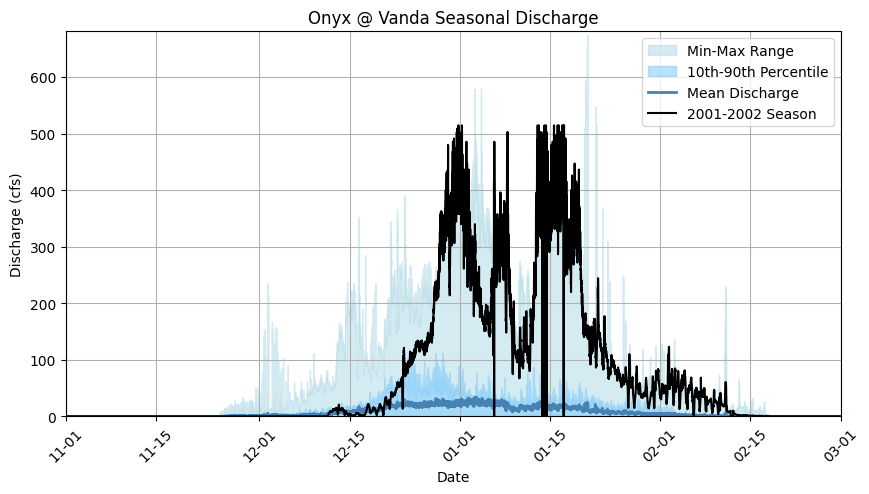

In [4]:
# Create data frame with only selected season
season_data = filtered_df[filtered_df['actual_season'] == selected_season].copy()

# Apply date formatting to single season data
season_data.loc[:, 'plot_date'] = season_data['mdhm'].apply(lambda x: f'2000-{x}' if x >= '11-01' else f'2001-{x}')
season_data['plot_date'] = pd.to_datetime(season_data['plot_date'], format='%Y-%m-%d %H:%M')

# Group by time of year and calculate summary statistics for each time point
stats = (filtered_df.groupby('mdhm')['cfs'].agg(mean_discharge='mean',min_discharge='min',max_discharge='max',perc_10=lambda x: np.percentile(x, 10),perc_90=lambda x: np.percentile(x, 90),).reset_index())

# Remove February 29 from the dataset (again)
stats = stats[stats['mdhm'] != '02-29']

# Apply date formatting to summary dataset
stats['plot_date'] = stats['mdhm'].apply(lambda x: f'2000-{x}' if x >= '11-01' else f'2001-{x}')
stats['plot_date'] = pd.to_datetime(stats['plot_date'], format='%Y-%m-%d %H:%M')
stats = stats.sort_values(by='plot_date')

# Generate plot
fig, ax = plt.subplots(figsize=(10, 5))

# Light blue shading for min-max range
ax.fill_between(stats['plot_date'],stats['min_discharge'],stats['max_discharge'],color='lightblue',alpha=0.5,label='Min-Max Range',)

# Darker blue shading for 10th-90th percentile
ax.fill_between(stats['plot_date'],stats['perc_10'],stats['perc_90'],color='lightskyblue',alpha=0.6,label='10th-90th Percentile',)

# Dark blue line for the average over full record
ax.plot(stats['plot_date'],stats['mean_discharge'],color='steelblue',linewidth=2,label='Mean Discharge',)

# Black line for selected season data
ax.plot(season_data['plot_date'],season_data['cfs'],color='black',linewidth=1.5,label=f'{selected_season} Season',)

# Axis limits
ax.set_xlim([pd.to_datetime('2000-11-01'), pd.to_datetime('2001-03-01')])
ax.set_ylim([0, stats['max_discharge'].max() + 5])  

# Label, title, and legend generation
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
ax.set_title('Onyx @ Vanda Seasonal Discharge')
ax.legend()

#Final formatting
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=45)
plt.show()

##### Total Annual Discharge over Full Record

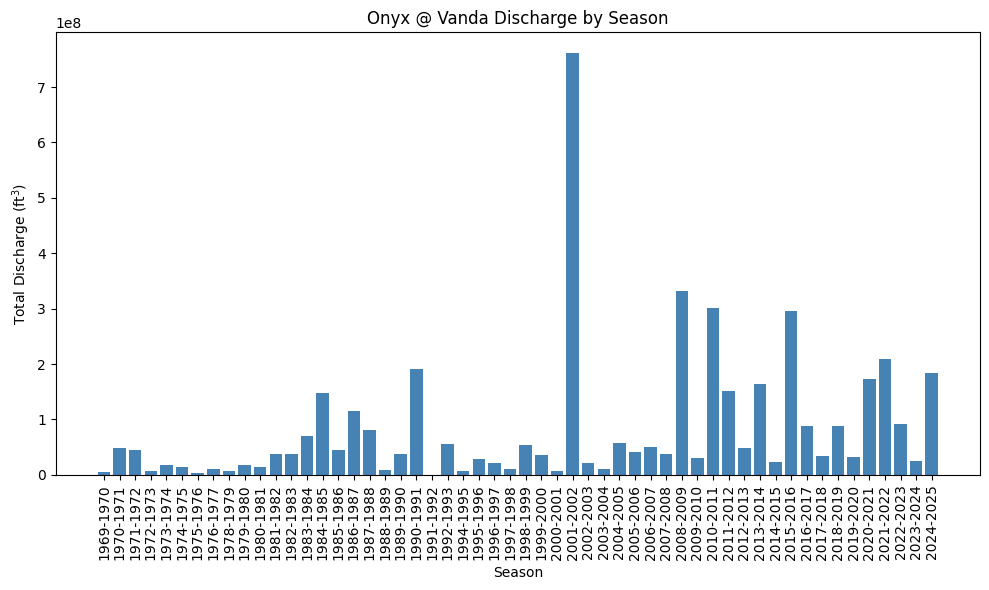

In [44]:
# Create a data frame including the sum of discharge for each season
season_sums = filtered_data.groupby('actual_season')['cfd'].sum().reset_index()

# Plot the summed discharge values in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(season_sums['actual_season'], season_sums['cfd'], color='steelblue')

# Add labels and title
plt.xlabel('Season')
plt.ylabel('Total Discharge (ft$^3$)')
plt.title('Onyx @ Vanda Discharge by Season')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

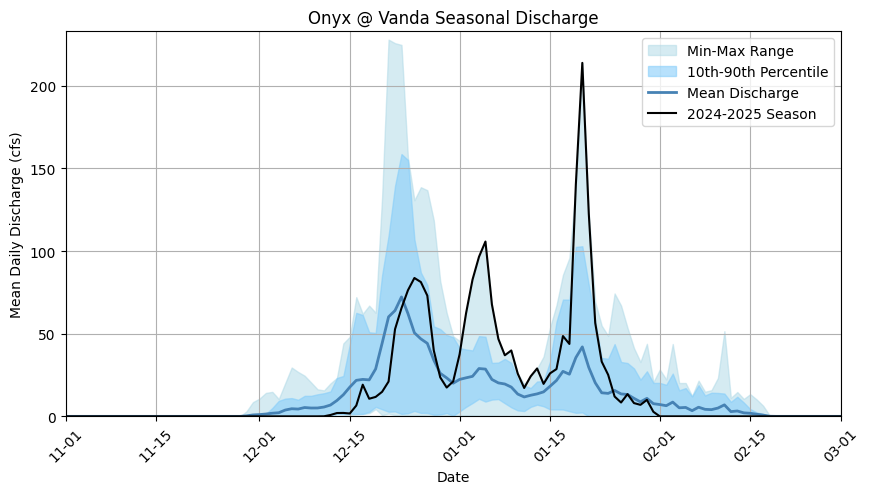

In [65]:
# Filter data for the selected season
season_data = filtered_data[filtered_data['actual_season'] == selected_season]

# Get the current year
current_year = pd.to_datetime('today').year

# Filter the seasons to include only the last 10 years
last_10_years = [f'{year}-{year+1}' for year in range(current_year - 10, current_year)]

# Filter the data for the last 10 years
filtered_data_10y = filtered_data[filtered_data['actual_season'].isin(last_10_years)]

# Create a copy of the slice to avoid the warning
season_data = season_data.copy()

# Apply the date formatting safely with .loc[]
season_data.loc[:, 'plot_date'] = season_data['month_day'].apply(
    lambda x: f'2000-{x}' if x >= '11-01' else f'2001-{x}'
)
season_data['plot_date'] = pd.to_datetime(season_data['plot_date'], format='%Y-%m-%d')

# Group by month-day and compute statistics (without 2001-2002)
stats = (
    filtered_data_10y.groupby('month_day')['mean_cfs']
    .agg(
        mean_discharge='mean',
        min_discharge='min',
        max_discharge='max',
        perc_10=lambda x: np.percentile(x, 10),
        perc_90=lambda x: np.percentile(x, 90),
    )
    .reset_index()
)

# Remove February 29 from the dataset
stats = stats[stats['month_day'] != '02-29']

# Assign a year based on the month-day value
stats['plot_date'] = stats['month_day'].apply(
    lambda x: f'2000-{x}' if x >= '11-01' else f'2001-{x}'
)

# Convert to datetime format
stats['plot_date'] = pd.to_datetime(stats['plot_date'], format='%Y-%m-%d')

# Sort by the new datetime column
stats = stats.sort_values(by='plot_date')

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))

# Light blue shading for 25-75 range
ax.fill_between(
    stats['plot_date'],
    stats['min_discharge'],
    stats['max_discharge'],
    color='lightblue',
    alpha=0.5,
    label='Min-Max Range',
)

# Darker blue shading for 10th-90th percentile range
ax.fill_between(
    stats['plot_date'],
    stats['perc_10'],
    stats['perc_90'],
    color='lightskyblue',
    alpha=0.6,
    label='10th-90th Percentile',
)

# Main line plot for the average discharge
ax.plot(
    stats['plot_date'],
    stats['mean_discharge'],
    color='steelblue',
    linewidth=2,
    label='Mean Discharge',
)

ax.plot(
    season_data['plot_date'],
    season_data['mean_cfs'],
    color='black',
    linewidth=1.5,
    label=f'{selected_season} Season',
)

ax.set_xlim([pd.to_datetime('2000-11-01'), pd.to_datetime('2001-03-01')])

# Set the y-axis to start at 0
ax.set_ylim(
    [0, stats['max_discharge'].max() + 5]
)  # Adjust y-axis upper limit for some space

# Formatting
ax.set_xlabel('Date')
ax.set_ylabel('Mean Daily Discharge (cfs)')
ax.set_title('Onyx @ Vanda Seasonal Discharge')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Rotate x-axis labels for clarity
plt.xticks(rotation=45)
plt.show()

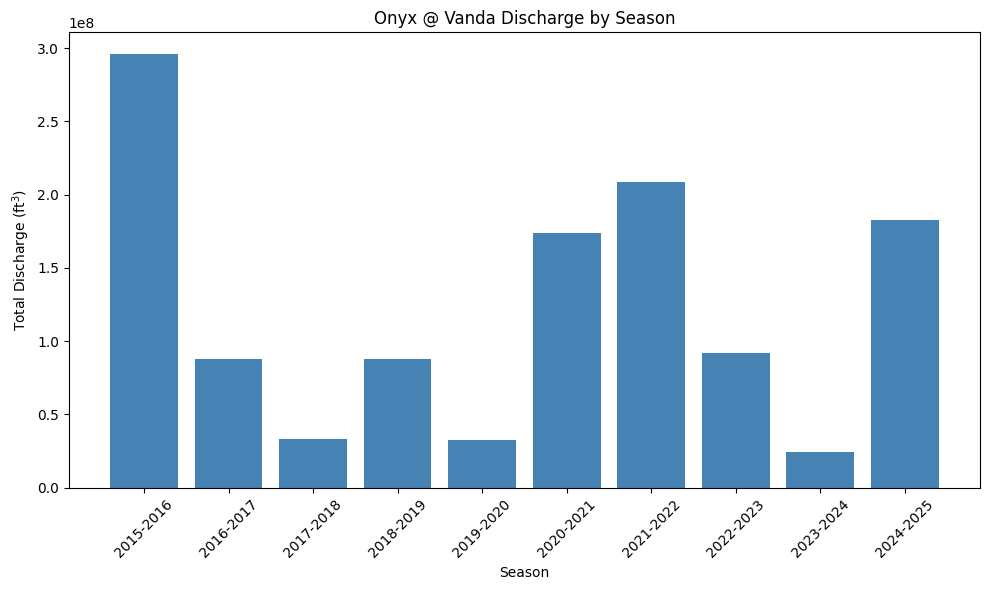

In [58]:
# Group by actual_season and sum tdaily_discharge for each season
season_sums_10y = filtered_data_10y.groupby('actual_season')['cfd'].sum().reset_index()

# Plot the summed discharge values in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(season_sums_10y['actual_season'], season_sums_10y['cfd'], color='steelblue')

# Add labels and title
plt.xlabel('Season')
plt.ylabel('Total Discharge (ft$^3$)')
plt.title('Onyx @ Vanda Discharge by Season')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()